In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
import os
import zipfile
import tqdm

file_name = "Multimedia_dataset.zip"
zip_path = os.path.join('/content/drive/MyDrive/4-1/멀티미디어/Multimedia_dataset.zip')
test_file_name = "noise_test_dataset.zip"
test_zip_path = os.path.join('/content/drive/MyDrive/4-1/멀티미디어/noise_test_dataset.zip')

!cp "{zip_path}" .
!unzip -q "{file_name}"
!rm "{file_name}"

!cp "{test_zip_path}" .
!unzip -q "{test_file_name}"
!rm "{test_file_name}"

trainset len:  4500
valset len:  500
testset len:  1000
train examples ['image_003390.png', 'image_001049.png', 'image_000981.png', 'image_001421.png', 'image_002944.png']
val examples ['image_004766.png', 'image_001343.png', 'image_001274.png', 'image_002068.png', 'image_001067.png']
test examples ['170.png', '461.png', '195.png', '282.png', '960.png']


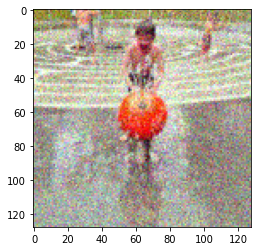

In [ ]:
import torch
import os
import matplotlib.pyplot as plt

train_root = './train'
val_root = './validation'
aug_root = './train'
test_root = './noise_25'

train_examples = os.listdir(train_root)
val_examples = os.listdir(val_root)
aug_examples = os.listdir(train_root)
test_examples = os.listdir(test_root)

print('trainset len: ', len(train_examples))
print('valset len: ', len(val_examples))
print('testset len: ', len(test_examples))

print('train examples', train_examples[:5])
print('val examples', val_examples[:5])
print('test examples', test_examples[:5])

img = plt.imread(test_root + '/' + test_examples[0])
plt.imshow(img)
plt.show()

In [ ]:
# data+noise 코드
def add_noise(img, noise) :
  #for i, data in enumerate(tqdm.tqdm(train_dataloader)):
    '''
    if use_cuda:
      img = data['img'].to('cuda')
      noise = data['noise'].to('cuda')
      '''
    model_input = img + noise
    noise_image = torch.clamp(model_input, 0, 1)

    #image_show(img[0])
    #image_show(noise_image[0])
    #input()
    
    return noise_image

image shape (256, 256, 3)


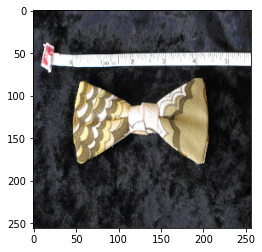

In [ ]:
import torch
import torch.utils.data  as data
import os
from PIL import Image
import matplotlib.pyplot as plt

class NoiseDataset(data.Dataset):
  def __init__(self, root_path, size):
    super(NoiseDataset, self).__init__()
    self.root_path = root_path
    self.size = size
    self.transforms = None
    self.examples = None

  def set_mode(self, mode):
    self.mode = mode
    self.transforms = NoiseTransform(self.size, mode)
    if mode == "training":
      train_dir = os.path.join(self.root_path, "train")
      self.examples = [os.path.join(self.root_path, "train", dirs) for dirs in os.listdir(train_dir)]
    elif mode == "augmented" or mode == "augmented2":
      aug_dir = os.path.join(self.root_path, "train")
      self.examples = [os.path.join(self.root_path, "train", dirs) for dirs in os.listdir(aug_dir)]
    elif mode == "validation":
      val_dir = os.path.join(self.root_path, "validation")
      self.examples = [os.path.join(self.root_path, "validation", dirs) for dirs in os.listdir(val_dir)]
    elif mode == "testing":
      test_dir = os.path.join(self.root_path, "noise_25")
      self.examples = [os.path.join(self.root_path, "noise_25", dirs) for dirs in os.listdir(test_dir)]
    else:
      raise NotImplementedError
  
  def __len__(self):
    return len(self.examples)
  
  def __repr__(self) :
    return "NoiseDataset(mode = {}, image_size = {})" .\
    format(self.mode, self.size)
  
  def __getitem__(self, idx):
    file_name = self.examples[idx]
    image = Image.open(file_name)

    if self.mode == "testing":
      input_img = self.transforms(image)
      #file_name = "image_%0.6d.png" % int(os.path.basename(test_file_name).split('.')[0])
      #sample = {"img" : input_img, "file_name" : file_name}
      return input_img

    elif self.mode == "augmented" or self.mode == "augmented2":
      augmented, noise = self.transforms(image)
      noise_aug = add_noise(augmented, noise)
      return noise_aug, augmented

    else:
      clean, noise = self.transforms(image)
      noise_img = add_noise(clean, noise)
      return noise_img, clean
    
print('image shape', img.shape)
plt.imshow(img)
plt.show()

In [ ]:
import torch
from torch.autograd import Variable
from torchvision import transforms

import random

class NoiseTransform(object):
  def __init__(self, size=180, mode="training"):
    super(NoiseTransform, self).__init__()
    self.size = size 
    self.mode = mode
  
  def gaussian_noise(self, img):
    mean = 0
    stddev = 25
    noise = Variable(torch.zeros(img.size()))
    noise = noise.data.normal_(mean, stddev/255.)

    return noise

  def __call__(self, img):
    if (self.mode == "training") | (self.mode == "validation"):
      self.gt_transform = transforms.Compose([
        # transforms.RandomCrop(self.size), 
        transforms.Resize((self.size, self.size), interpolation=2),# 이미지 크기 조절
        transforms.ToTensor()])
      self.noise_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor(),
        transforms.Lambda(self.gaussian_noise),
      ])
      return self.gt_transform(img), self.noise_transform(img)

    elif self.mode == "augmented" :
      self.aug_transform = transforms.Compose([
        # transforms.RandomCrop(self.size), #이미지 자르기
        transforms.Resize((self.size, self.size), interpolation=2),# 이미지 크기 조절
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),#밝기, 대비, 채도, 색조 등 바꾸는 기능
        transforms.RandomHorizontalFlip(p=1), #p의 확률로 좌우반전 실시
        transforms.ToTensor(),                                  
      ])
      self.noise_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor(),
        transforms.Lambda(self.gaussian_noise),
      ])
      return self.aug_transform(img), self.noise_transform(img)

    elif self.mode == "augmented2" :
      self.aug_transform2 = transforms.Compose([
        # transforms.RandomCrop(self.size), #이미지 자르기
        transforms.Resize((self.size, self.size), interpolation=2),# 이미지 크기 조절
        transforms.RandomGrayscale(p=1),#밝기, 대비, 채도, 색조 등 바꾸는 기능
        transforms.RandomVerticalFlip(p=1), # 30도 회전
        transforms.ToTensor(),                                  
      ])
      self.noise_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor(),
        transforms.Lambda(self.gaussian_noise),
      ])
      return self.aug_transform2(img), self.noise_transform(img)

    elif self.mode == "testing":
      self.gt_transform = transforms.Compose([
        # transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor()])
      return self.gt_transform(img)
    else:
      return NotImplementedError

In [ ]:
import torch
import torch.utils.data  as data
from torch.utils.data import ConcatDataset
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
from PIL import Image

# Change to your data root directory
root_path = "/content/"
# Depend on runtime setting
use_cuda = True

train_dataset = NoiseDataset(root_path, 128)
train_dataset.set_mode("training")
train_dataloader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

train_aug_dataset = NoiseDataset(root_path, 128)
train_aug_dataset.set_mode("augmented")
train_aug_dataloader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

train_aug_dataset2 = NoiseDataset(root_path, 128)
train_aug_dataset2.set_mode("augmented2")
train_aug_dataloader2 = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

# train 합치기
modified_dataset = ConcatDataset([train_dataset, train_aug_dataset])
print(len(modified_dataset))

val_dataset = NoiseDataset(root_path, 128)
val_dataset.set_mode("validation")
val_dataloader = data.DataLoader(val_dataset, batch_size=4, shuffle=True)

test_dataset = NoiseDataset(root_path, 128)
test_dataset.set_mode("testing")
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)

9000


* Plotting and Image Functions

In [ ]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [ ]:
def plot(exp, fig, axes, noisy, img, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[np.newaxis].to(exp.net.device))[0]

    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    axes[1][2].clear()

    myimshow(img, ax=axes[0][0])
    axes[0][0].set_title('Original image')
    myimshow(noisy, ax=axes[0][1])
    axes[0][1].set_title('Noisy image')
    myimshow(denoised, ax=axes[0][2])
    axes[0][2].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="training loss")
    axes[1][0].set_title('training loss')
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="psnr")
    axes[1][1].set_title('psnr')
    axes[1][2].plot([exp.history[k][0]['ssim'] for k in range(exp.epoch)], label="ssim")
    axes[1][2].set_title('ssim')     
    
    plt.tight_layout()
    fig.canvas.draw()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Text(0.5, 1.0, 'Noise Image')

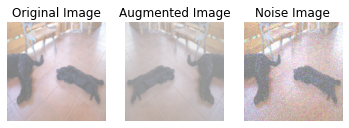

In [ ]:
x, x_aug = train_dataset[30], train_aug_dataset[30]
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
myimshow(x[1], ax=ax1)
ax1.set_title("Original Image")
myimshow(x_aug[1], ax=ax2)
ax2.set_title("Augmented Image")
myimshow(x[0], ax=ax3)
ax3.set_title("Noise Image")

* NNRegressor

In [ ]:
import nntools as nt

class NNRegressor(nt.NeuralNetwork):
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.loss = nn.MSELoss()
        
    def criterion(self, y, d):
        return self.loss(y, d)

* Stat Manager

In [ ]:
import pytorch_ssim

class DenoisingStatsManager(nt.StatsManager):

  def __init__(self):
    super(DenoisingStatsManager, self).__init__()

  def init(self):
    super(DenoisingStatsManager, self).init()
    self.running_psnr = 0
    self.count = 0
    self.ssim_value = 0
    self.ssim_loss = 0

  def accumulate(self, loss, x, y, d):
    super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
    mse = torch.sum((y-d)**2).float()
    self.running_psnr += 10 * torch.log10((4*y.numel())/mse)
    self.count += 1
    self.ssim_value += pytorch_ssim.ssim(y, d)
    loss = pytorch_ssim.SSIM(window_size = 11)
    self.ssim_loss += loss(y,d)

  def summarize(self):
    loss = super(DenoisingStatsManager, self).summarize()
    psnr = self.running_psnr / self.count
    ssim = self.ssim_value / self.count
    return {'loss':loss, 'psnr':psnr, 'ssim':ssim}

* 다른 DuDnCNN

In [ ]:
class DUDnCNN2(NNRegressor):

    def __init__(self, D, C=64):
        super(DUDnCNN2, self).__init__()
        self.D = D

        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])

        # holes and dilations for convolution layers
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k, l)]
        dilations = [i+1 for i in holes]

        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(
            nn.Conv2d(3, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1],
                                    dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(
            nn.Conv2d(C, 3, 3, padding=dilations[-1], dilation=dilations[-1]))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(
                self.conv[i].weight.data, nonlinearity='relu')

        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            h_buff.append(h)

        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))

        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))

        y = self.conv[D+1](h) + x
        return y

In [ ]:
lr = 1e-3
net = DUDnCNN2(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp61 = nt.Experiment(net, modified_dataset, val_dataset, adam, stats_manager, batch_size = 4,
                     output_dir="denoising61", perform_validation_during_training=True)

Start/Continue training from epoch 1


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Epoch 2 | Time: 181.26s | Training Loss: 0.000833 | Evaluation Loss: 0.000901
Epoch 3 | Time: 180.38s | Training Loss: 0.000807 | Evaluation Loss: 0.000953
Epoch 4 | Time: 180.48s | Training Loss: 0.000793 | Evaluation Loss: 0.000966
Epoch 5 | Time: 181.13s | Training Loss: 0.000787 | Evaluation Loss: 0.000923
Epoch 6 | Time: 181.27s | Training Loss: 0.000783 | Evaluation Loss: 0.000886
Epoch 7 | Time: 181.19s | Training Loss: 0.000776 | Evaluation Loss: 0.000938
Epoch 8 | Time: 181.04s | Training Loss: 0.000776 | Evaluation Loss: 0.000927
Epoch 9 | Time: 180.86s | Training Loss: 0.000774 | Evaluation Loss: 0.000882
Epoch 10 | Time: 180.80s | Training Loss: 0.000769 | Evaluation Loss: 0.000872
Epoch 11 | Time: 180.60s | Training Loss: 0.000771 | Evaluation Loss: 0.000906
Epoch 12 | Time: 180.41s | Training Loss: 0.000765 | Evaluation Loss: 0.000897
Epoch 13 | Time: 180.19s | Training Loss: 0.000767 | Evaluation Loss: 0.000895
Epoch 14 | Time: 180.53s | Training Loss: 0.000767 | Evaluat

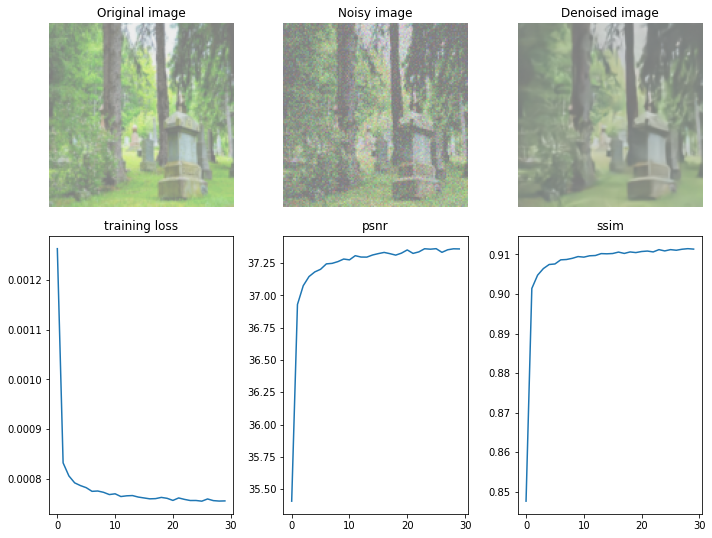

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10,8))
exp61.run(num_epochs=30, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=train_aug_dataset[500][0], img = train_aug_dataset[500][1]))

* Show results

In [ ]:
eval3 = exp31.evaluate()
eval5 = exp51.evaluate()

print("DUDnCNN loss", eval3["loss"])
print("Augmented DUDnCNN loss", eval5["loss"])
print("DUDnCNN psnr", eval3["psnr"].cpu().numpy())
print("Augmented DUDnCNN psnr", eval5["psnr"].cpu().numpy())
print("DUDnCNN ssim", eval3["ssim"].cpu().numpy())
print("Augmented DUDnCNN ssim", eval5["ssim"].cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


DUDnCNN loss 0.001518519213423133
Augmented DUDnCNN loss 0.00085038712923415
DUDnCNN psnr 34.23951
Augmented DUDnCNN psnr 36.806576
DUDnCNN ssim 0.82722014
Augmented DUDnCNN ssim 0.90678436


In [ ]:
eval1 = exp11.evaluate()
eval2 = exp21.evaluate()
eval3 = exp31.evaluate()
eval4 = exp51.evaluate()
eval5 = exp61.evaluate()

print("loss of DnCNN : {} \nloss of UDnCNN : {} \nloss of DUDnCNN : {} \nloss of DUDnCNN(D=7) : {} \nloss of DUDnCNN with augmentation : {}"
      .format(eval1["loss"],eval2["loss"],eval3["loss"],eval4["loss"],eval5["loss"]))

print("PSNR of DnCNN : {} \nPSNR of UDnCNN : {} \nPSNR of DUDnCNN : {} \nPSNR of DUDnCNN(D=7) : {} \nPSNR of DUDnCNN with augmentation: {}"
      .format(eval1["psnr"].cpu().numpy(), eval2["psnr"].cpu().numpy(), eval3["psnr"].cpu().numpy(), eval4["psnr"].cpu().numpy(), eval5["psnr"].cpu().numpy()))

print("SSIM of DnCNN : {} \nSSIM of UDnCNN : {} \nSSIM of DUDnCNN : {} \nSSIM of DUDnCNN(D=7) : {} \nSSIM of DUDnCNN with augmentation: {}\n"
      .format(eval1["ssim"].cpu().numpy(), eval2["ssim"].cpu().numpy(), eval3["ssim"].cpu().numpy(), eval4["ssim"].cpu().numpy(), eval5["ssim"].cpu().numpy()))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


loss of DnCNN : 0.0009420836009085178 
loss of UDnCNN : 0.0009514648946933449 
loss of DUDnCNN : 0.0008778677904047072 
loss of DUDnCNN(D=7) : 0.0008783816318027676 
loss of DUDnCNN with augmentation : 0.0008855201452970504
PSNR of DnCNN : 36.34273910522461 
PSNR of UDnCNN : 36.30836868286133 
PSNR of DUDnCNN : 36.66351318359375 
PSNR of DUDnCNN(D=7) : 36.67378234863281 
PSNR of DUDnCNN with augmentation: 36.626060485839844
SSIM of DnCNN : 0.8892436623573303 
SSIM of UDnCNN : 0.8938115835189819 
SSIM of DUDnCNN : 0.9030708074569702 
SSIM of DUDnCNN(D=7) : 0.9011508226394653 
SSIM of DUDnCNN with augmentation: 0.9015880823135376



* Test dataset







  0%|          | 0/1000 [00:00<?, ?it/s]

image_000000








  0%|          | 1/1000 [00:00<04:08,  4.01it/s]





  1%|          | 7/1000 [00:00<02:58,  5.56it/s]

image_000001
image_000002
image_000003
image_000004
image_000005
image_000006
image_000007
image_000008
image_000009








  1%|▏         | 13/1000 [00:00<02:16,  7.25it/s]





  2%|▏         | 19/1000 [00:00<01:40,  9.80it/s]





  2%|▎         | 25/1000 [00:00<01:14, 13.01it/s]





  3%|▎         | 31/1000 [00:00<00:57, 16.88it/s]





  4%|▎         | 36/1000 [00:01<00:52, 18.43it/s]





  4%|▍         | 42/1000 [00:01<00:41, 23.08it/s]





  5%|▍         | 48/1000 [00:01<00:34, 27.99it/s]





  5%|▌         | 53/1000 [00:01<00:36, 26.22it/s]





  6%|▌         | 59/1000 [00:01<00:30, 31.11it/s]





  6%|▋         | 65/1000 [00:01<00:26, 35.39it/s]





  7%|▋         | 70/1000 [00:02<00:30, 30.60it/s]





  8%|▊         | 76/1000 [00:02<00:26, 35.10it/s]





  8%|▊         | 82/1000 [00:02<00:23, 39.14it/s]





  9%|▊         | 87/1000 [00:02<00:28, 32.52it/s]





  9%|▉         | 93/1000 [00:02<00:24, 36.81it/s]





 10%|▉         | 99/1000 [00:02<00:22, 40.39it/s]





 10%|█         | 104/1000 [00:02<00:25, 35.50it/s]





 11%|█         | 110/1000 [00:02<00:22, 39.68it/s]





 1

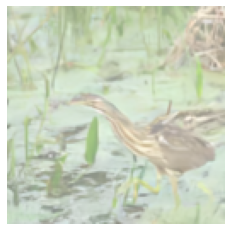

In [ ]:
from PIL import Image
from torchvision.utils import save_image

def image_save(img, path):
  #trans = transforms.ToPILImage()
  #img_data = trans(img)
  #img_data.save(path, 'png')
  path += '.png'
  save_image(img, path)

result_save_path = '/content/drive/MyDrive/4-1/멀티미디어/result3'
for i, data in enumerate(tqdm.tqdm(test_dataloader)):
  noisy = test_dataset[i]
  #exp61.evaluate()

  with torch.no_grad():
    out_test = exp61.net(noisy[np.newaxis].to(exp61.net.device))[0]
    myimshow(out_test)
    if i < 10 :
      file_name = 'image_00000' + str(i)
      print(file_name)
    elif i < 100 : 
      file_name = 'image_0000' + str(i)
    elif i < 1000 : 
      file_name = 'image_000' + str(i)
    image_save(out_test, os.path.join(result_save_path, file_name))

In [ ]:
def showImageFromAllNets(idx):
    noisy = test_dataset[idx] #if we call test_set again, we will get a different crop
    with torch.no_grad():
        dncnn = exp11.net(noisy[np.newaxis].to(exp11.net.device))[0]
        udncnn = exp21.net(noisy[np.newaxis].to(exp21.net.device))[0]
        dudncnn = exp31.net(noisy[np.newaxis].to(exp31.net.device))[0]

    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(10,6), sharex='all', sharey='all')
    axes[0].set_title("Test dataset")
    myimshow(noisy, axes[0])
    axes[1].set_title("DnCNN")
    myimshow(dncnn, axes[1])
    axes[2].set_title("UDnCNN")
    myimshow(udncnn, axes[2])
    axes[3].set_title("DUDnCNN")
    myimshow(dudncnn, axes[3])
    print(dudncnn.shape)

In [ ]:
showImageFromAllNets(10)

--------------------------------------------------